## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [1]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [2]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [3]:
# Model settings
modelName = 'stockScreenerV1.5'
trainingData = 'stockData.csv'
getNewData = False 
trainNewModel = True
predictionTarget = 'DRS'  # 'ALL' for all, 'amount%', 'None' for no prediction

# Training parameters
trainingSize = 300  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 256
epochs = 25

# Testing parameters
testSize = 100  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [4]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [5]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [6]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [7]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [8]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [9]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

## Model Training

In [10]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Learning rate finder results: lr_min=0.00043651582673192023, lr_steep=1.0964781722577754e-06
Training for 3 epochs...


epoch,train_loss,valid_loss,_rmse,mae,time
0,62.414963,17.742189,4.212148,0.439332,00:14
1,115.745956,0.303777,0.551160,0.385195,00:14
2,87.964005,0.608104,0.779810,0.401185,00:14


Model training complete


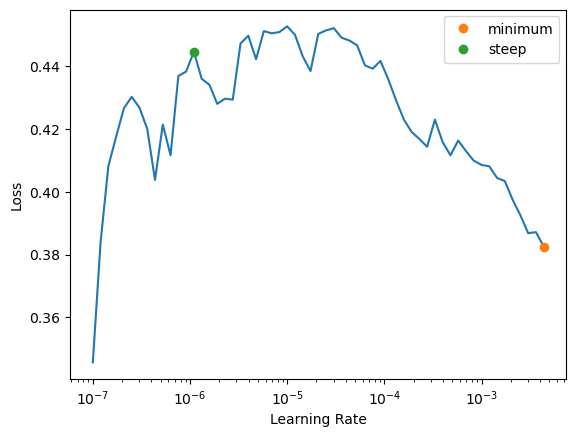

In [11]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: lr_min={lr_min}, lr_steep={lr_steep}")

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$TCB-B: possibly delisted; no timezone found


Error fetching data for TCB-B: No historical data available for TCB-B around 2024-01-27.


$AKP: possibly delisted; no timezone found


Error fetching data for AKP: No historical data available for AKP around 2024-01-27.


$FCE.B: possibly delisted; no timezone found


Error fetching data for FCE.B: No historical data available for FCE.B around 2024-01-27.


$TFG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TFG: No historical data available for TFG around 2024-01-27.


$DSPG: possibly delisted; no timezone found


Error fetching data for DSPG: No historical data available for DSPG around 2024-01-27.


$NNC-G: possibly delisted; no timezone found


Error fetching data for NNC-G: No historical data available for NNC-G around 2024-01-27.


$TSRA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TSRA: No historical data available for TSRA around 2024-01-27.


$CORE: possibly delisted; no timezone found


Error fetching data for CORE: No historical data available for CORE around 2024-01-27.


$HTA: possibly delisted; no timezone found


Error fetching data for HTA: No historical data available for HTA around 2024-01-27.


$HMTV: possibly delisted; no timezone found


Error fetching data for HMTV: No historical data available for HMTV around 2024-01-27.


$CUI: possibly delisted; no timezone found


Error fetching data for CUI: No historical data available for CUI around 2024-01-27.


$MZOR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MZOR: No historical data available for MZOR around 2024-01-27.


Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


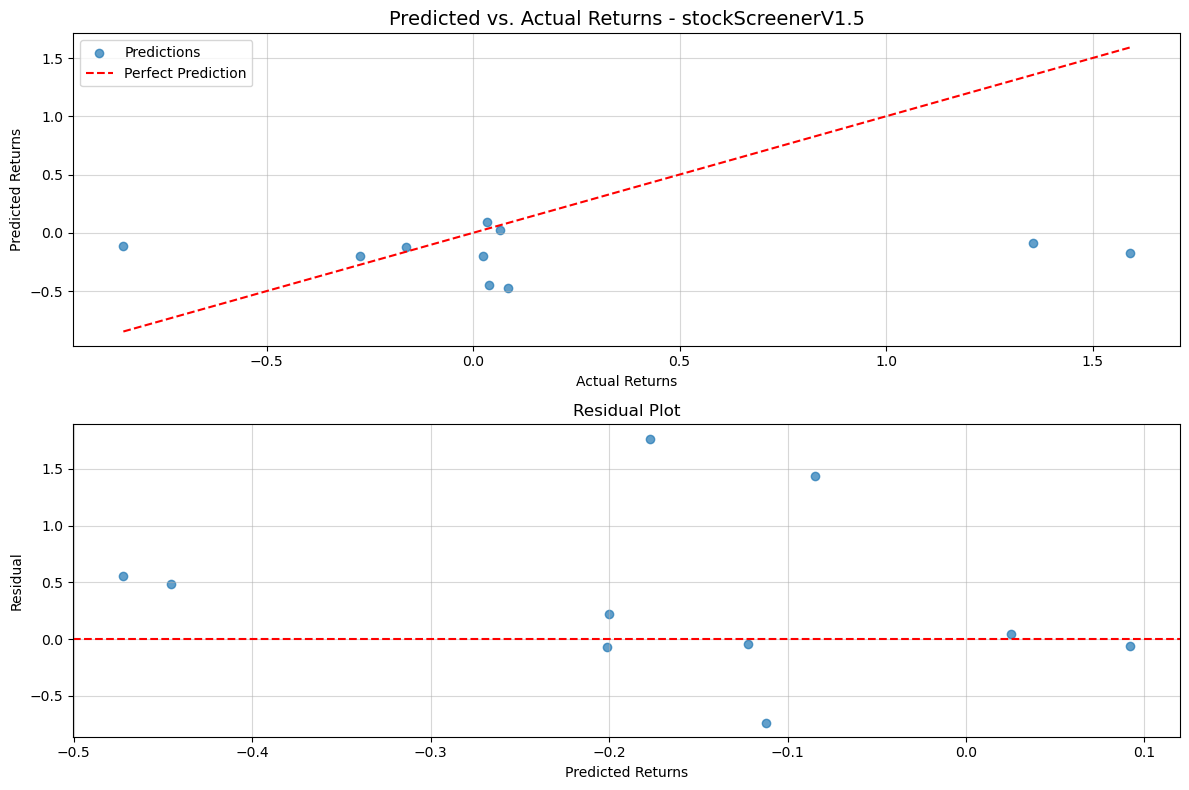

Collected 10 valid test tickers (target: 10)

Evaluation Results:
MAE: 0.542
RMSE: 0.797
R²: -0.313


In [12]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [13]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.5.pkl
stockScreenerV1.4.pkl
stockScreenerV1.3.pkl
stockScreenerV1.2.pkl
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl


In [14]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.1
Timestamp      2025-01-26 11:53
MAE                       0.393
RMSE                       0.91
R2                       -2.938
Name: 1, dtype: object

### Load model

In [15]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [16]:
#predictionTarget = 'SAABF'

In [17]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

Prediction for DRS (Unknown):
-6.98%
Free money?!
